<a href="https://colab.research.google.com/github/inkatown/QueChuaWordVec/blob/main/WordVecQuechuaMagazine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPDF2 pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00


In [2]:
import PyPDF2
import pandas as pd
import re
from typing import List, Tuple

def extract_text_from_pdf(pdf_path: str, start_page: int, end_page: int) -> List[str]:
    """
    Extract text from PDF pages within the specified range.

    Args:
        pdf_path: Path to the PDF file
        start_page: First page to process (1-based index)
        end_page: Last page to process (inclusive)

    Returns:
        List of text strings for each page
    """
    pages_text = []

    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)

        # Validate page range
        if start_page < 1 or end_page > len(reader.pages):
            raise ValueError("Invalid page range")

        # Extract text from each page in range
        for page_num in range(start_page - 1, end_page):
            page = reader.pages[page_num]
            text = page.extract_text()
            if text:  # Only add if text was extracted
                pages_text.append(text)

    return pages_text

def identify_titles_and_articles(text_pages: List[str]) -> List[Tuple[str, str]]:
    """
    Identify titles and articles from extracted text pages.

    Args:
        text_pages: List of text strings from PDF pages

    Returns:
        List of tuples (title, article)
    """
    title_article_pairs = []
    current_title = None
    current_article = []

    # Patterns to identify titles (adjust based on your magazine's formatting)
    title_patterns = [
        r'\n[A-Z][A-Z\s\-]+\n',  # ALL CAPS titles
        r'\n\d+\.\s+[A-Z][a-zA-Z\s]+\n',  # Numbered titles
        r'\n[A-Z][a-zA-Z\s]+:\n',  # Titles ending with colon
    ]

    for page in text_pages:
        # Split page into lines
        lines = page.split('\n')

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Check if line matches a title pattern
            is_title = any(re.fullmatch(pattern, f'\n{line}\n') for pattern in title_patterns)

            if is_title:
                # If we have a previous article, save it before starting new one
                if current_title and current_article:
                    title_article_pairs.append((
                        current_title,
                        ' '.join(current_article).strip()
                    ))
                    current_article = []

                current_title = line
            else:
                if current_title:  # Only collect article text if we have a title
                    current_article.append(line)

    # Add the last article if it exists
    if current_title and current_article:
        title_article_pairs.append((
            current_title,
            ' '.join(current_article).strip()
        ))

    return title_article_pairs

def create_magazine_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame from a PDF magazine with title and article columns.

    Args:
        pdf_path: Path to the PDF file
        start_page: First page to process (default: 5)
        end_page: Last page to process (default: 58)

    Returns:
        pandas DataFrame with 'title' and 'article' columns
    """
    pdf_files =[["/content/REVISTA UNAYPACHA  No. 1.pdf" ,5,58 ],
     ["/content/REVISTA UNAYPACHA No. 2.pdf" ,7,105 ],
     ["/content/REVISTA UNAYPACHA No. 3.pdf" ,7,110 ],
     ["/content/REVISTA UNAYPACHA No. 4.pdf" ,7,148 ],
     ["/content/REVISTA UNAYPACHA No. 5.pdf" ,7,138],
    ["/content/REVISTA. UNAYPACHA No. 6-7.pdf" ,7,190]]
    pages_text = []
    for pdf_file in pdf_files:
      pdf_path = pdf_file[0]
      start_page = pdf_file[1]
      end_page = pdf_file[2]
        # Extract text from PDF
      pages_text += extract_text_from_pdf(pdf_path, start_page, end_page)

    # Identify titles and articles
    title_article_pairs = identify_titles_and_articles(pages_text)

    # Create DataFrame
    df = pd.DataFrame(title_article_pairs, columns=['title', 'article'])

    return df

In [35]:
if __name__ == "__main__":
    # Example usage

    try:
        magazine_df = create_magazine_dataframe()
        print(f"Successfully created DataFrame with {len(magazine_df)} articles")
        print(magazine_df.head())

        # Optionally save to CSV
        magazine_df.to_csv("magazine_articles.csv", index=False)
        print("Data saved to magazine_articles.csv")
        # Optionally save to piclke object
    except Exception as e:
        print(f"Error processing PDF: {e}")

Successfully created DataFrame with 92 articles
                                               title  \
0                                         YACHAYKUNA   
1                                         RIQSIYKUNA   
2  Chaymi anti suyupi runakunaqa kaynata yuyayman...   
3                                         MUSYAYKUNA   
4  Qipa punchawtas Sisariy mamaku chayta musyaspa...   

                                             article  
0  11Pachamamanchikmanta yuyaymanasqay Mauro A. D...  
1  31Taqwirisunchik maymanta kasqanchikta, kallpa...  
2  - Runakuna, pachamamawan, apukunawan ima kuska...  
3  45Sisariypa suñakuynin Heberth Loa-Gonzales Un...  
4  ¿Imaynanpitaq wak runaqa llaqtaymanqa llapa ay...  
Data saved to magazine_articles.csv


In [37]:
magazine_df.to_pickle('unaypacha.pkl') #optionally pickle magazines

In [3]:
magazine_df = pd.read_pickle('unaypacha.pkl')

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import re
import nltk

class QuechuaWordVectors:
    def __init__(self, window_size=4, vector_size=100):
        """
        Initialize the word vector builder.

        Args:
            window_size: Size of context window for co-occurrence
            vector_size: Dimension of final word vectors
        """
        self.window_size = window_size
        self.vector_size = vector_size
        self.word2idx = {}
        self.idx2word = {}
        self.cooccurrence_matrix = None
        self.word_vectors = None

    def preprocess_text(self, text):
        """Basic text preprocessing for Quechua with simple tokenization"""
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation (adjust for Quechua punctuation if needed)
        text = re.sub(r'[^\w\s]', '', text)
        # Simple whitespace tokenizer (works better for Quechua than NLTK's English tokenizer)
        tokens = text.split()
        return tokens

    def build_vocabulary(self, texts):
        """Build vocabulary from all texts"""
        word_counts = defaultdict(int)

        for text in texts:
            tokens = self.preprocess_text(text)
            for token in tokens:
                word_counts[token] += 1

        # Sort words by frequency and assign indices
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        self.word2idx = {word: idx for idx, (word, count) in enumerate(sorted_words)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        return self.word2idx

    def build_cooccurrence_matrix(self, texts):
        """Build co-occurrence matrix from texts"""
        vocab_size = len(self.word2idx)
        self.cooccurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

        for text in texts:
            tokens = self.preprocess_text(text)
            token_ids = [self.word2idx[token] for token in tokens if token in self.word2idx]

            for i, target_id in enumerate(token_ids):
                # Get context words within window
                start = max(0, i - self.window_size)
                end = min(len(token_ids), i + self.window_size + 1)

                for j in range(start, end):
                    if j == i:
                        continue  # skip the target word itself
                    context_id = token_ids[j]
                    # Add to co-occurrence count (you could use distance weighting here)
                    self.cooccurrence_matrix[target_id, context_id] += 1.0 / (abs(i - j) + 1)

        # Apply smoothing and scaling if desired
        self.cooccurrence_matrix = np.log(1 + self.cooccurrence_matrix)
        return self.cooccurrence_matrix

    def train(self, texts):
        """Train word vectors using SVD on co-occurrence matrix"""
        # Build vocabulary and co-occurrence matrix
        self.build_vocabulary(texts)
        self.build_cooccurrence_matrix(texts)

        # Apply dimensionality reduction
        svd = TruncatedSVD(n_components=self.vector_size, random_state=42)
        self.word_vectors = svd.fit_transform(self.cooccurrence_matrix)

        return self.word_vectors

    def get_vector(self, word):
        """Get vector for a specific word"""
        if word not in self.word2idx:
            return None
        return self.word_vectors[self.word2idx[word]]

    def most_similar(self, word, topn=5):
        """Find most similar words based on cosine similarity"""
        if word not in self.word2idx:
            return []

        vec = self.get_vector(word)
        similarities = []

        for other_word, idx in self.word2idx.items():
            if other_word == word:
                continue
            other_vec = self.word_vectors[idx]
            sim = np.dot(vec, other_vec) / (np.linalg.norm(vec) * np.linalg.norm(other_vec))
            similarities.append((other_word, sim))

        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:topn]

    def save_vectors(self, filepath):
        """Save word vectors to file"""
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(f"{len(self.word2idx)} {self.vector_size}\n")
            for word, idx in self.word2idx.items():
                vector_str = ' '.join(map(str, self.word_vectors[idx]))
                f.write(f"{word} {vector_str}\n")



In [6]:
# Example usage with your DataFrame
if __name__ == "__main__":
    #df = pd.read_csv('magazine_articles.csv')
    df = magazine_df

    # Combine all article text
    all_texts = df['article'].tolist()

    # Initialize and train the word vectors
    qwv = QuechuaWordVectors(window_size=3, vector_size=50)
    word_vectors = qwv.train(all_texts)

    # Example operations
    print("Vocabulary size:", len(qwv.word2idx))
    print("Vector for 'quechua':", qwv.get_vector('quechua')[:5])  # Show first 5 dimensions
    print("Most similar to 'kuyay':", qwv.most_similar('kuyay'))

    # Save vectors to file
    qwv.save_vectors('quechua_vectors.txt')
    print("Word vectors saved to quechua_vectors.txt")

Vocabulary size: 35855
Vector for 'quechua': [1.681877   5.7531395  0.5173124  0.08232827 0.19057077]
Most similar to 'kuyay': [('hutikunata', np.float32(0.96231943)), ('hutikuna', np.float32(0.9552341)), ('imanaw', np.float32(0.9532212)), ('imanawpis', np.float32(0.95189416)), ('kastillanu', np.float32(0.9505958))]
Word vectors saved to quechua_vectors.txt


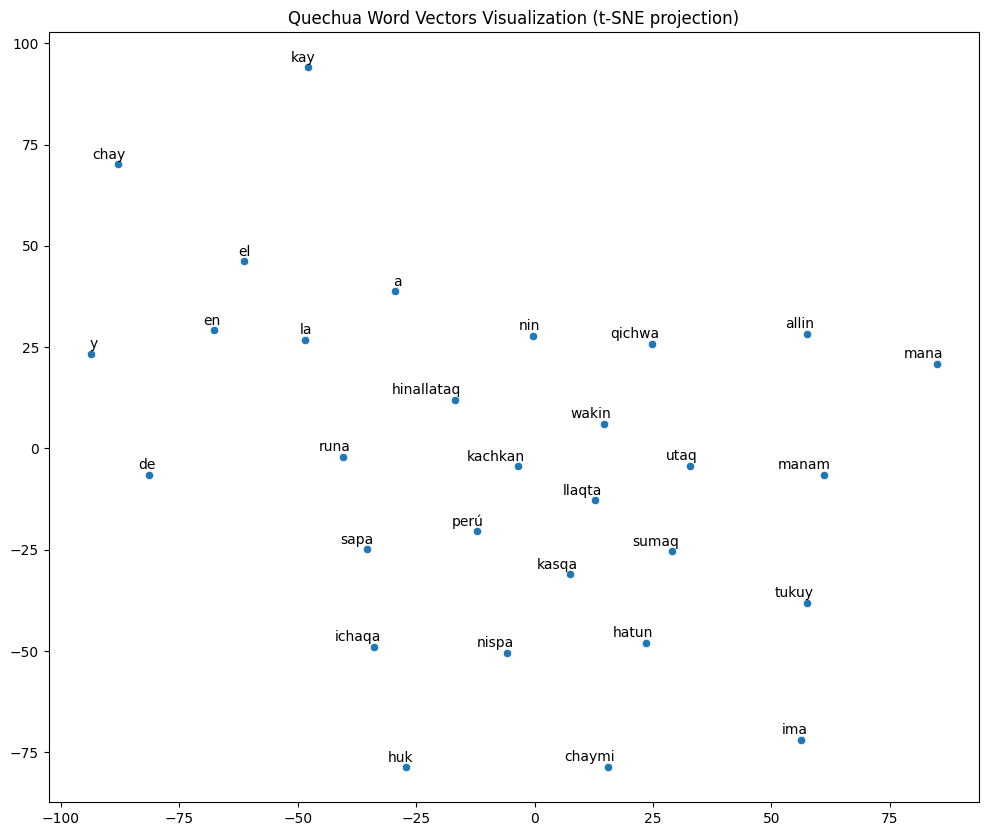

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_word_vectors(word_vector_model, num_words=50):
    """
    Visualize word vectors using t-SNE for dimensionality reduction

    Args:
        word_vector_model: Trained QuechuaWordVectors instance
        num_words: Number of words to visualize (top most frequent)
    """
    # Get the most frequent words
    words = list(word_vector_model.word2idx.keys())[:num_words]
    vectors = np.array([word_vector_model.get_vector(word) for word in words])

    # Reduce dimensionality to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, num_words-1))
    vectors_2d = tsne.fit_transform(vectors)

    # Create plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1])

    # Add word labels
    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom', fontsize=10)

    plt.title("Quechua Word Vectors Visualization (t-SNE projection)")
    plt.show()

# Add this to your main execution block after training
visualize_word_vectors(qwv, num_words=30)

In [8]:
from sklearn.decomposition import PCA

def visualize_with_pca(word_vector_model, num_words=50):
    words = list(word_vector_model.word2idx.keys())[:num_words]
    vectors = np.array([word_vector_model.get_vector(word) for word in words])

    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    plt.figure(figsize=(12, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))

    plt.title("Word Vectors (PCA projection)")
    plt.show()

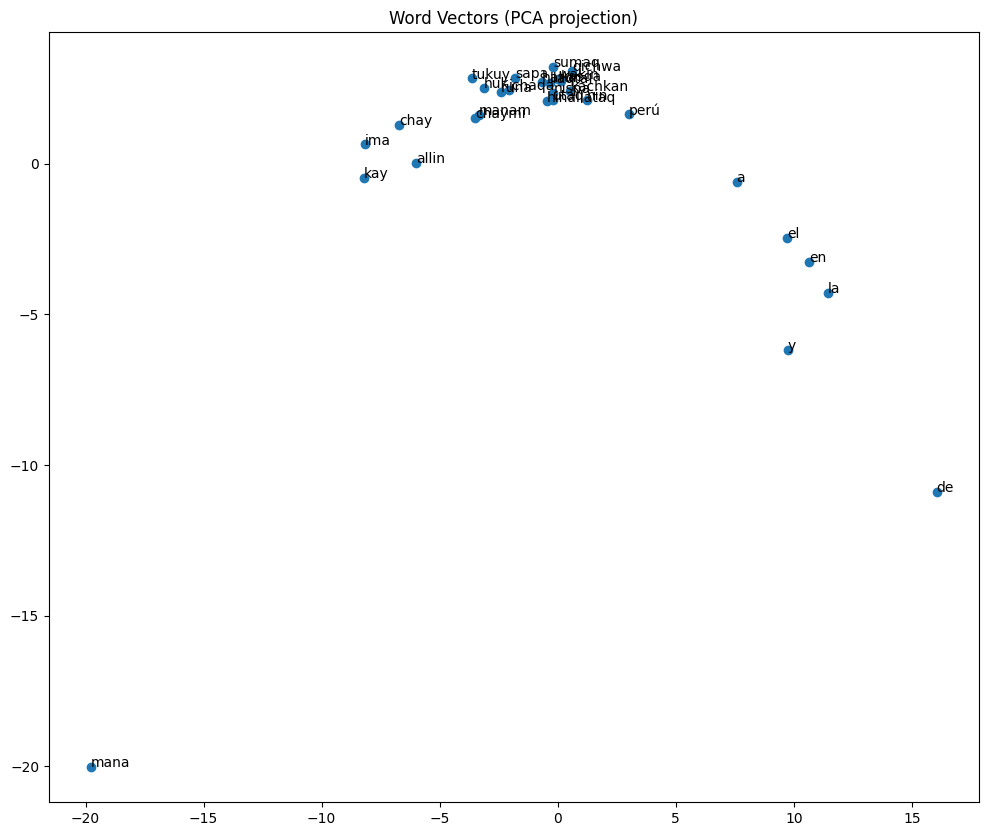

In [9]:
visualize_with_pca(qwv, num_words=30)

In [10]:
import plotly.express as px

def interactive_visualization(word_vector_model, num_words=50):
    words = list(word_vector_model.word2idx.keys())[:num_words]
    vectors = np.array([word_vector_model.get_vector(word) for word in words])

    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)

    fig = px.scatter(x=vectors_2d[:, 0], y=vectors_2d[:, 1], text=words)
    fig.update_traces(textposition='top center')
    fig.update_layout(title_text='Quechua Word Vectors Visualization')
    fig.show()

In [11]:
interactive_visualization(qwv, num_words=50)